In [131]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("talk")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.tree import DecisionTreeClassifier


Notebooks de referencia: (para borrar antes de entrega)

https://www.kaggle.com/code/clemwo/bitcoin-transactions-graph-neural-networks

https://www.kaggle.com/code/nidropakshin/ellptic-data-gat-tagnn

https://www.kaggle.com/code/karthikapv/licit-illicit-logistic-regression



### Descripción del dataset

Continuaremos trabajando con Elliptic Data Set, presentado por Weber et al. en 2019 [1], el cual contiene datos anonimizados de 203,769 transacciones de Bitcoin. De la documentación del dataset sabemos que:

2% de las transacciones están clasificadas como ilícitas (clase 1), 21% como lícitas (clase 2) y el 77% restante no ha sido etiquetado (clase 0). 

#### Features 
Cada transacción corresponde a un intervalo temporal de 3 hs (time step). Los time step son índices del 1 al 49 y están espaciados entre sí por dos semanas. Cada time step contiene un componente de transacciones conectadas entre sí, y desconectadas del resto de los componentes. 

De cada transacción se incluyen también 166 variables (features) cuya descripción exacta no es provista, pero se dan rasgos generales:

##### Features directas de la transacción (1 a 94)
Las primeras 94 features representan información directa de la transacción. Esto incluye al time-step, la cantidad de inputs/outputs, la tarifa de transacción, el volumen de output, así como variables agregadas tales como la cantidad promedio de BTC recibido (gastado) por los inputs/outputs y el número promedio de transacciones entrantes asociadas con los inputs/outpus.

Estas son estadísticas directamente relacionadas con:
- Cómo se construyó la transacción
- De qué magnitud es
- Qué tan activa es la wallet involucrada
- Cuánto dinero se movió

##### Features agregadas de transacciones vecinas (95 a 166)
Las 72 features restantes provee estadísticas agregadas de las transacciones vecinas (una arista de distancia). Para cada variable incluida en las features directas, se calculan agregados (máximo, mínimo, desvío estándar y coeficientes de correlación) de las transacciones vecinas. 

In [132]:
# Cargar los archivos
features = pd.read_csv("../data/kaggle/elliptic_txs_features.csv", header=None)
edges = pd.read_csv("../data/kaggle/elliptic_txs_edgelist.csv")
classes = pd.read_csv("../data/kaggle/elliptic_txs_classes.csv")

# Renombrar columnas para claridad
# features = features.rename(columns={0: "txId", 1: "time_step"})
edges = edges.rename(columns={"txId1": "source", "txId2": "target"})
classes = classes.rename(columns={"txId": "txId", "class": "label"})



In [133]:
# renombrar columnas para mayor claridad
tx_features = ["tx_feat_"+str(i) for i in range(2,95)]
agg_features = ["agg_feat_"+str(i) for i in range(1,73)]
features.columns = ["txId","time_step"] + tx_features + agg_features

In [134]:
print(f"""Shapes
{4*' '}Features : {features.shape[0]:8,} (rows)  {features.shape[1]:4,} (cols)
{4*' '}Classes  : {classes.shape[0]:8,} (rows)  {classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {edges.shape[0]:8,} (rows)  {edges.shape[1]:4,} (cols)
""")



Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



#### Armado de dataset para modelado

In [135]:
# merge with classes
df_features = pd.merge(features, classes, left_on='txId', right_on='txId', how='left')

In [136]:
df_features['label'] = df_features['label'].apply(lambda x: '0' if x == "unknown" else x)

In [137]:
# chequeamos que las clases nos quedaron bien armadas
df_features.groupby('label').size()

label
0    157205
1      4545
2     42019
dtype: int64

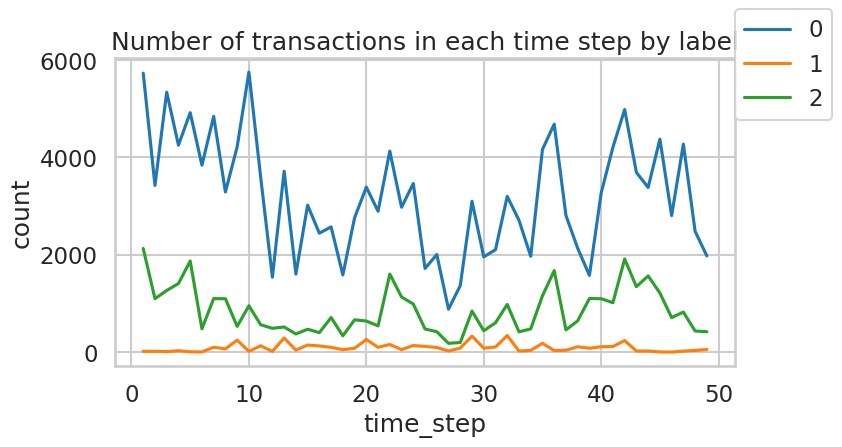

In [138]:
plt.figure(figsize=(8, 4))
grouped = df_features.groupby(['time_step', 'label'])['txId'].count().reset_index().rename(columns={'txId': 'count'})
sns.lineplot(x='time_step', y='count', hue='label', data=grouped);
plt.legend(loc=(1.0, 0.8));
plt.title('Number of transactions in each time step by label');

## Entrenamiento de Modelos

### Preprocesamiento

In [139]:
# Cantidad de filas con al menos un valor nulo
num_rows_with_nan = df_features.isnull().any(axis=1).sum()

# Cantidad de datos faltantes por variable
missing_per_col = df_features.isnull().sum()

(num_rows_with_nan, missing_per_col)



(np.int64(0),
 txId           0
 time_step      0
 tx_feat_2      0
 tx_feat_3      0
 tx_feat_4      0
               ..
 agg_feat_69    0
 agg_feat_70    0
 agg_feat_71    0
 agg_feat_72    0
 label          0
 Length: 168, dtype: int64)

In [140]:
# nos quedamos con datos etiquetados
data = df_features[(df_features['label']=='1') | (df_features['label']=='2')]

# creamos series para modelado
X = data[['time_step'] + tx_features+agg_features]
y = data['label'].astype(int)

In [142]:
# división entre entrenamiento y evaluación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

In [143]:
# distribución de variable target en subconjuntos de train y test
print("Distribución original:", y.value_counts(normalize=True))
print("Train:", y_train.value_counts(normalize=True))
print("Test:", y_test.value_counts(normalize=True))

Distribución original: label
2    0.902392
1    0.097608
Name: proportion, dtype: float64
Train: label
2    0.901452
1    0.098548
Name: proportion, dtype: float64
Test: label
2    0.906153
1    0.093847
Name: proportion, dtype: float64


## Modelos lineales

### Evaluando el poder explicativo de tx_features y agg_features

#### Regresión logística

In [ ]:
# Asegurarse de que las etiquetas estén en formato int y sin clase '2'

y = data['label'].astype(int)

# División en train/test
X_tx = data[tx_features]
X_agg = data[agg_features]
X_all = data[tx_features + agg_features]

X_train_tx, X_test_tx, y_train, y_test = train_test_split(X_tx, y, test_size=0.3, random_state=42)
X_train_agg, X_test_agg = train_test_split(X_agg, test_size=0.3, random_state=42)
X_train_all, X_test_all = train_test_split(X_all, test_size=0.3, random_state=42)

# Escalado (opcional pero recomendado)
scaler_tx = StandardScaler().fit(X_train_tx)
scaler_agg = StandardScaler().fit(X_train_agg)
scaler_all = StandardScaler().fit(X_train_all)

X_train_tx = scaler_tx.transform(X_train_tx)
X_test_tx = scaler_tx.transform(X_test_tx)

X_train_agg = scaler_agg.transform(X_train_agg)
X_test_agg = scaler_agg.transform(X_test_agg)

X_train_all = scaler_all.transform(X_train_all)
X_test_all = scaler_all.transform(X_test_all)

# Entrenar modelos
def eval_model(X_train, y_train, X_test, y_test, name):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n🔹 Resultados usando {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

# Evaluar cada grupo de features
eval_model(X_train_tx, y_train, X_test_tx, y_test, "solo features de transacción")
eval_model(X_train_agg, y_train, X_test_agg, y_test, "solo features agregadas")
eval_model(X_train_all, y_train, X_test_all, y_test, "todas las features")



🔹 Resultados usando solo features de transacción
Accuracy: 0.9076592698639943
Precision: 0.6678700361010831
Recall: 0.13376717281272596
F1 score: 0.22289156626506024
Matriz de confusión:
 [[  185  1198]
 [   92 12495]]

🔹 Resultados usando solo features agregadas
Accuracy: 0.916034359341446
Precision: 0.7536231884057971
Recall: 0.22559652928416485
F1 score: 0.34724540901502504
Matriz de confusión:
 [[  312  1071]
 [  102 12485]]

🔹 Resultados usando todas las features
Accuracy: 0.9584108804581245
Precision: 0.8369747899159664
Recall: 0.720173535791757
F1 score: 0.7741935483870968
Matriz de confusión:
 [[  996   387]
 [  194 12393]]


#### Clasificador por gradiente

In [ ]:
y = data['label'].astype(int)

# Divisiones con estratificación
X_tx = data[tx_features]
X_agg = data[agg_features]
X_all = data[tx_features + agg_features]

X_train_tx, X_test_tx, y_train, y_test = train_test_split(
    X_tx, y, test_size=0.3, random_state=42, stratify=y
)
X_train_agg, X_test_agg = train_test_split(
    X_agg, test_size=0.3, random_state=42, stratify=y
)
X_train_all, X_test_all = train_test_split(
    X_all, test_size=0.3, random_state=42, stratify=y
)

# Escalado
scaler_tx = StandardScaler().fit(X_train_tx)
scaler_agg = StandardScaler().fit(X_train_agg)
scaler_all = StandardScaler().fit(X_train_all)

X_train_tx = scaler_tx.transform(X_train_tx)
X_test_tx = scaler_tx.transform(X_test_tx)

X_train_agg = scaler_agg.transform(X_train_agg)
X_test_agg = scaler_agg.transform(X_test_agg)

X_train_all = scaler_all.transform(X_train_all)
X_test_all = scaler_all.transform(X_test_all)

# Evaluación con SGDClassifier
def eval_sgd(X_train, y_train, X_test, y_test, name):
    clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n🔹 Resultados usando {name} (SGDClassifier)")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 score:", f1_score(y_test, y_pred))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))

# Ejecutar evaluaciones
eval_sgd(X_train_tx, y_train, X_test_tx, y_test, "solo features de transacción")
eval_sgd(X_train_agg, y_train, X_test_agg, y_test, "solo features agregadas")
eval_sgd(X_train_all, y_train, X_test_all, y_test, "todas las features")



🔹 Resultados usando solo features de transacción (SGDClassifier)
Accuracy: 0.9088761632068719
Precision: 0.5986984815618221
Recall: 0.20234604105571846
F1 score: 0.30246575342465754
Matriz de confusión:
 [[  276  1088]
 [  185 12421]]

🔹 Resultados usando solo features agregadas (SGDClassifier)
Accuracy: 0.9234073013600572
Precision: 0.7370967741935484
Recall: 0.3350439882697947
F1 score: 0.46068548387096775
Matriz de confusión:
 [[  457   907]
 [  163 12443]]

🔹 Resultados usando todas las features (SGDClassifier)
Accuracy: 0.9591982820329277
Precision: 0.8538324420677362
Recall: 0.7023460410557185
F1 score: 0.7707160096540627
Matriz de confusión:
 [[  958   406]
 [  164 12442]]


#### Buscando el mejor modelo

In [154]:
# Métricas función
def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }



In [ ]:
X_all = data[tx_features + agg_features]

# Split (sin escalar afuera)
X_train_all, X_test_all, y_train, y_test = train_test_split(
    X_all, y, test_size=0.3, random_state=42, stratify=y
)

# ========= ColumnTransformer =========
numeric_features = X_all.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

# ========= Pipeline base =========
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(random_state=42))
])

# ========= Hiperparámetros =========
param_grid = {
    'classifier__loss': ['log_loss', 'hinge', 'modified_huber'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['constant', 'optimal', 'invscaling'],
    'classifier__eta0': [0.001, 0.01, 0.1]
}

# ========= GridSearchCV =========
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train_all, y_train)

# Resultados: f1 promedio y varianza
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

# Resultados
results_table = pd.DataFrame(params)
results_table['mean_f1'] = means
results_table['std_f1'] = stds

# Mejor configuración: entrenando al mejor modelo
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Evaluación
y_train_pred = best_estimator.predict(X_train_all)
y_test_pred = best_estimator.predict(X_test_all)


results_train = metrics(y_train, y_train_pred)
results_test = metrics(y_test, y_test_pred)

results_table.sort_values(by='mean_f1', ascending=False).head(10), best_params, results_train, results_test

(    classifier__alpha  classifier__eta0 classifier__learning_rate  \
 4              0.0001             0.001                   optimal   
 13             0.0001             0.010                   optimal   
 22             0.0001             0.100                   optimal   
 3              0.0001             0.001                   optimal   
 12             0.0001             0.010                   optimal   
 21             0.0001             0.100                   optimal   
 23             0.0001             0.100                   optimal   
 14             0.0001             0.010                   optimal   
 5              0.0001             0.001                   optimal   
 31             0.0010             0.001                   optimal   
 
    classifier__loss   mean_f1    std_f1  
 4             hinge  0.781892  0.038922  
 13            hinge  0.781892  0.038922  
 22            hinge  0.781892  0.038922  
 3          log_loss  0.763745  0.011008  
 12         l

In [157]:
# imprimir hiperparámetros del mejor modelo
print(best_params)


{'classifier__alpha': 0.0001, 'classifier__eta0': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'hinge'}


In [ ]:
# Evaluar el modelo entrenado
print("\n📊 Evaluación en conjunto de TEST (modelo final)")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1 Score:", f1_score(y_test, y_test_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_test_pred))



📊 Evaluación en conjunto de TEST (modelo final)
Accuracy: 0.9616320687186829
Precision: 0.8404605263157895
Recall: 0.749266862170088
F1 Score: 0.7922480620155039
Matriz de confusión:
 [[ 1022   342]
 [  194 12412]]


El mejor modelo encontrado es un clasificador tipo SVM lineal entrenado con SGD, con baja regularización y un learning rate adaptativo.

Obtiene un F1 score promedio de 0.78, que es bastante bueno para un problema con clases desbalanceadas como este.

Este modelo tiene un buen equilibrio entre recall y precisión. 

## Decision tree

## Referencias


1. M. Weber, G. Domeniconi, J. Chen, D. K. I. Weidele, C. Bellei, T. Robinson, C. E. Leiserson, "Anti-Money Laundering in Bitcoin: Experimenting with Graph Convolutional Networks for Financial Forensics", KDD ’19 Workshop on Anomaly Detection in Finance, August 2019, Anchorage, AK, USA.